<a href="https://colab.research.google.com/github/SaketMunda/time-series-with-tensorflow/blob/master/time_series_exercise_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises of Time Series using TensorFlow

This notebook contains the exercises covered for topic Time series forecasting using TensorFlow.


1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
  -  Try doing this for a univariate model (e.g. `model_1`) and a multivariate model (e.g. `model_6`) and see if it effects model training or evaluation results.
2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
  -  You can download the Bitcoin historical data for free from coindesk.com/price/bitcoin and clicking "Export Data" -> "CSV".
3. For most of our models we used `WINDOW_SIZE=7`, but is there a better window size?
  -  Setup a series of experiments to find whether or not there's a better window size.
  -  For example, you might train 10 different models with `HORIZON=1` but with window sizes ranging from 2-12.
4. Create a windowed dataset just like the ones we used for `model_1` using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array) and retrain `model_1` using the recreated dataset.
5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
  - Are there any other features you think you could add?
  - If so, try it out, how do these affect the model?
6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for `model_8`.
7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn't retrained for every forecast (`model_9`)?
8. Throughout this notebook, we've only tried algorithms we've handcrafted ourselves. But it's worth seeing how a purpose built forecasting algorithm goes.
  - Try out one of the extra algorithms listed in the modelling experiments part such as:
    - [Facebook's Kats library](https://github.com/facebookresearch/Kats) - there are many models in here, remember the machine learning practioner's motto: experiment, experiment, experiment.
    - [LinkedIn's Greykite library](https://github.com/linkedin/greykite)


In [ ]:
# check for gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4828a8f5-17a6-a5df-7d47-b92bbf67fcfd)


## Preparation prior to Exercise

In [1]:
# get the data
!wget https://github.com/SaketMunda/time-series-with-tensorflow/raw/master/BTC-USD-latest.csv

--2023-05-29 04:09:15--  https://github.com/SaketMunda/time-series-with-tensorflow/raw/master/BTC-USD-latest.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD-latest.csv [following]
--2023-05-29 04:09:15--  https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD-latest.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 260918 (255K) [text/plain]
Saving to: ‘BTC-USD-latest.csv’

BTC-USD-latest.csv  100%[===================>] 254.80K  --.-KB/s    in 0.004s  

2023-05-29 04:09:15 (58.4 MB/s) - ‘BTC-USD-latest.c

In [2]:
# importing the data using pandas
import pandas as pd

df = pd.read_csv("BTC-USD-latest.csv", parse_dates=["Date"], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-13,26807.769531,27030.482422,26710.873047,26784.078125,26784.078125,9.999172e+09
2023-05-14,26788.974609,27150.976563,26661.355469,26930.638672,26930.638672,1.001486e+10
2023-05-15,26931.384766,27646.347656,26766.097656,27192.693359,27192.693359,1.441323e+10
2023-05-16,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-17,27023.728516,27223.074219,26987.576172,27110.449219,27110.449219,1.219658e+10


In [ ]:
len(df)

3165

In [ ]:
len(df)/365

8.67123287671233

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3165 entries, 2014-09-17 to 2023-05-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3164 non-null   float64
 1   High       3164 non-null   float64
 2   Low        3164 non-null   float64
 3   Close      3164 non-null   float64
 4   Adj Close  3164 non-null   float64
 5   Volume     3164 non-null   float64
dtypes: float64(6)
memory usage: 173.1 KB


let's remove some of the columns first for our experiments, and keep only those who are useful for us.

In [3]:
bitcoin_prices = pd.DataFrame(df['Adj Close']).rename(columns={"Adj Close":"Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-13,26784.078125
2023-05-14,26930.638672
2023-05-15,27192.693359


In [26]:
# check if there is any NaN
bitcoin_prices[bitcoin_prices.Price.isna()]

,Price
Date,
2023-05-16,NaN


Since bitcoin price record is empty so we'll remove the last 2 dates and work only until 15th May 2023 data

In [27]:
bitcoin_prices = bitcoin_prices[:-2]

In [28]:
bitcoin_prices.tail()

,Price
Date,
2023-05-11,27000.789063
2023-05-12,26804.990234
2023-05-13,26784.078125
2023-05-14,26930.638672
2023-05-15,27192.693359


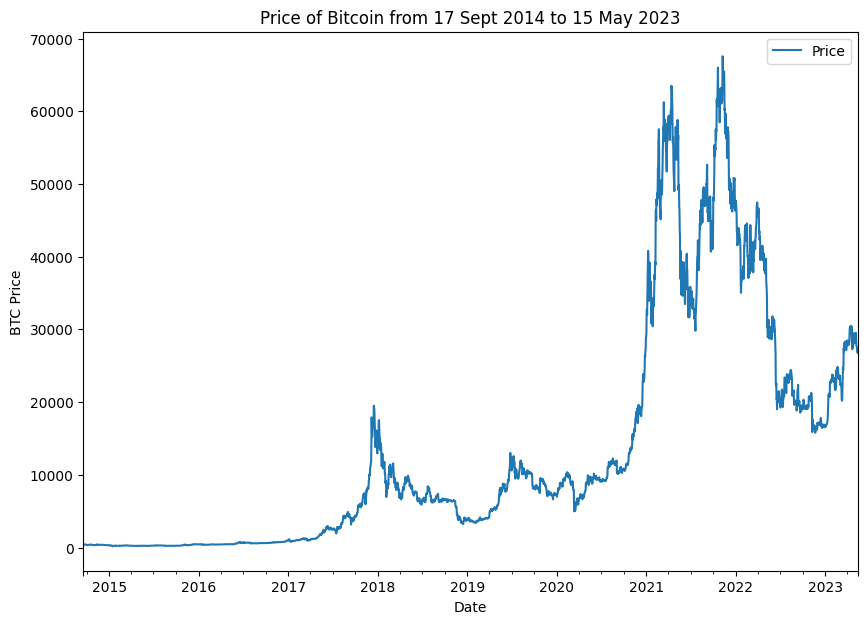

In [29]:
# let's plot the prices
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend()
plt.title("Price of Bitcoin from 17 Sept 2014 to 15 May 2023");

### Format Data : Part 1 : Create train and test sets for Time series data

In [30]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [31]:
split_size = int(len(timesteps) * 0.8) # 80% train and 20% test set
split_size 

2530

In [32]:
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

Now, we can visualize the data using plot

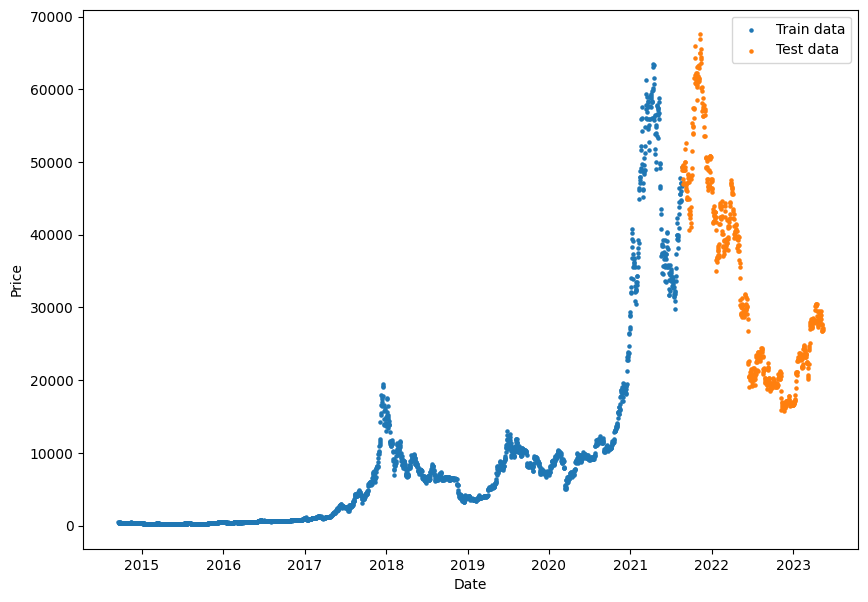

In [33]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

In [11]:
# creating a plotting function, because we need this function to visualize everytime when we do the modelling experiment
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  # plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

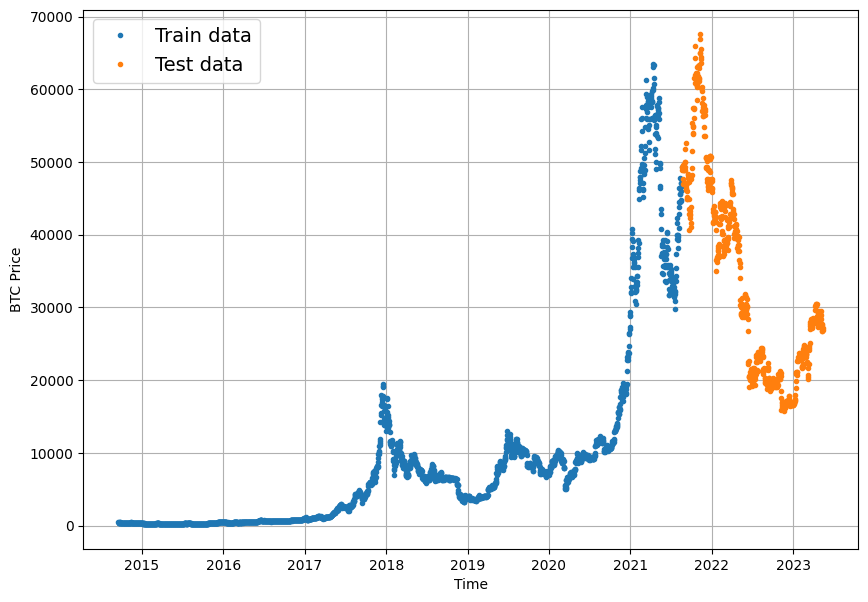

In [34]:
plt.figure(figsize=(10,7))
plot_time_series(X_train,y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

### Format Data Part 2 : Windowing dataset

In [35]:
HORIZON = 1
WINDOW_SIZE = 7

# create a function which takes an array as input and return it in form of window and horizon
def get_labelled_windows(x, horizon=1):
  """
  Create labels for windowed dataset
  Eg, if horizon=1 (default)
  Input: [1,2,3,4,5,6,7] -> Output: ([1,2,3,4,5,6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [36]:
# let's test it
import tensorflow as tf

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))

test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [37]:
# create a function to create window for entire dataset

import numpy as np

def make_windows(x, window_size=7,horizon=1):
  # 1. Create a window step fo specific window size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # default o/p [[1,2,3,4,5,6,7,8]]

  # 2. Use numpy indexing to create a 2D of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  # default o/p = 

  # 3. Uses the 2D array of multiple window steps to index on a target series
  windowed_array = x[window_indexes]

  # 4. Uses the `get_labelled_windows()` function we create above to turn the window steps into windows with a specified horizon.
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

## Exercise 1

Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
  -  Try doing this for a univariate model (e.g. `model_1`) and a multivariate model (e.g. `model_6`) and see if it effects model training or evaluation results.

### Scaling Univariate data

In [41]:
scaled_prices = prices / np.max(prices)
scaled_prices

array([0.00676862, 0.00628178, 0.00584304, ..., 0.39640869, 0.39857781,
       0.40245627])

In [42]:
scaled_full_windows, scaled_full_labels = make_windows(scaled_prices, window_size=WINDOW_SIZE, horizon=HORIZON)

len(scaled_full_windows),len(scaled_full_labels)

(3156, 3156)

In [43]:
# view the first 3 windows/labels
for i in range(3):
  print(f"Windows: {scaled_full_windows[i]}, Labels: {scaled_full_labels[i]}")

Windows: [0.00676862 0.00628178 0.00584304 0.00605185 0.00590262 0.00595191
 0.00644978], Labels: [0.0062635]
Windows: [0.00628178 0.00584304 0.00605185 0.00590262 0.00595191 0.00644978
 0.0062635 ], Labels: [0.00609136]
Windows: [0.00584304 0.00605185 0.00590262 0.00595191 0.00644978 0.0062635
 0.00609136], Labels: [0.00598556]


In [20]:
# turning windows into training and test sets
def make_train_test_split(windows, labels, test_split=0.2):
  
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [44]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(scaled_full_windows, scaled_full_labels)

train_windows[:5], train_labels[:5]

(array([[0.00676862, 0.00628178, 0.00584304, 0.00605185, 0.00590262,
         0.00595191, 0.00644978],
        [0.00628178, 0.00584304, 0.00605185, 0.00590262, 0.00595191,
         0.00644978, 0.0062635 ],
        [0.00584304, 0.00605185, 0.00590262, 0.00595191, 0.00644978,
         0.0062635 , 0.00609136],
        [0.00605185, 0.00590262, 0.00595191, 0.00644978, 0.0062635 ,
         0.00609136, 0.00598556],
        [0.00590262, 0.00595191, 0.00644978, 0.0062635 , 0.00609136,
         0.00598556, 0.00591296]]),
 array([[0.0062635 ],
        [0.00609136],
        [0.00598556],
        [0.00591296],
        [0.00558234]]))

### Experiment on `model_1`

In [45]:
# create a model checkpoint first
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

In [ ]:
# Dense Model

import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(17)

# construct a model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')    
], name='model_1_dense')


# compile a model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_1.name)])

In [48]:
## evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 0.0118 - mae: 0.0118


[0.011767175979912281, 0.011767175979912281]

In [49]:
# load the last saved model
model_1 = tf.keras.models.load_model(f'model_experiments/{model_1.name}')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 0.0115 - mae: 0.0115


[0.011476416140794754, 0.011476416140794754]

### Make Predictions

In [50]:
def make_predictions(model, input_data):
  y_preds = model.predict(input_data)
  return tf.squeeze(y_preds)

In [51]:
model_1_preds = make_predictions(model_1, test_windows)
model_1_preds[:10]

20/20 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.7270222 , 0.73058414, 0.732023  , 0.70765185, 0.7199855 ,
       0.69557655, 0.7177303 , 0.72311556, 0.7199252 , 0.7006377 ],
      dtype=float32)>

In [52]:
test_labels.shape, model_1_preds.shape

((632, 1), TensorShape([632]))

### Make Evaluation

In [54]:
# creating evaluation function
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE 
  """
  mae = tf.reduce_mean(y_true, y_pred)

  naive_mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:]), y_true[:-1])

  return mae / naive_mae_no_seasonality

In [59]:
def make_evaluation(y_true, y_pred):

  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy(),
          "mase":mase.numpy()}

In [58]:
model_1_results = make_evaluation(y_true=test_labels,
                                  y_pred=model_1_preds)

model_1_results

InvalidArgumentError: ignored